# 네이버 영화리뷰 감성분석 

## Data set = Movie reply from Naver

## 루브릭

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.

    3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

    gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

    네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함


In [1]:
#Data set 
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from tensorflow.keras.initializers import Constant
from konlpy.tag import Mecab
 
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 전처리하기

데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴


In [2]:

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'],inplace=True)
    train_data =  train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        t_X = tokenizer.morphs(sentence)#토크나이저 적용
        t_X = [word for word in t_X if not word in stopwords]#불용어 제거
        X_train.append(t_X)
        
    X_test = []
    for sentence in test_data['document']:
        t_X = tokenizer.morphs(sentence)#토크나이저 적용
        t_X = [word for word in t_X if not word in stopwords]#불용어 제거
        X_test.append(t_X)
        
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))


훈련 샘플 개수: 146182, 테스트 개수: 49157


In [3]:
#text,index key value 딕셔너리 위치 변경
index_to_word = {index:word for word, index in word_to_index.items()}


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.

<BOS>


### 모델구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))



문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)
X_train[0]

(146182, 41)
(49157, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

## 모델설계 

In [9]:
# 시험 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=17)

In [10]:
# 데이터 축소
# # validation set 20000건 분리 
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 50000건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(86945, 41)
(86945,)


## simple GlobalMaxPooling1D Model

In [11]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# simple GlobalMaxPooling1D Model
model1= keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [12]:
#epoch 효율을 위해 earlyStopping setting
from keras.callbacks import EarlyStopping
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5)]

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks= callbacks, 
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
170/170 [==============================] - 3s 10ms/step - loss: 0.6469 - accuracy: 0.7319 - val_loss: 0.4253 - val_accuracy: 0.8252
Epoch 2/20
170/170 [==============================] - 1s 7ms/step - loss: 0.3823 - accuracy: 0.8433 - val_loss: 0.3599 - val_accuracy: 0.8411
Epoch 3/20
170/170 [==============================] - 1s 7ms/step - loss: 0.3129 - accuracy: 0.8703 - val_loss: 0.3513 - val_accuracy: 0.8465
Epoch 4/20
170/170 [==============================] - 1s 7ms/step - loss: 0.2667 - accuracy: 0.8938 - val_loss: 0.3533 - val_accuracy: 0.8482
Epoch 5/20
170/170 [==============================] - 1s 7ms/step - loss: 0.2391 - accuracy: 0.9070 - val_loss: 0.3621 - val_accuracy: 0.8463
Epoch 6/20
170/170 [==============================] - 1s 7ms/step - loss: 0.2140 - accuracy: 0.9192 - val_loss: 0.3753 - val_accuracy: 0.8452
Epoch 7/20
170/170 [==============================] - 1s 7ms/step - loss: 0.1900 - accuracy: 0.9293 - val_loss: 0.3909 - val_accuracy: 0.8441
Epoch

In [13]:
#결과

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4181 - accuracy: 0.8393
[0.41806164383888245, 0.8392701148986816]


In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


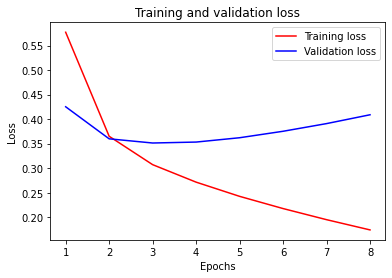

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# r은 "빨간 실선"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

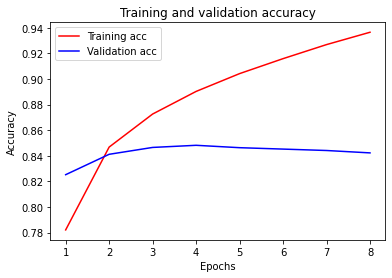

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## conv1D+ CNN Model

In [17]:
# conv1D+ CNN Model

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=callbacks, #epoch 효율을 위해 earlyStopping setting
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
170/170 [==============================] - 9s 29ms/step - loss: 0.6117 - accuracy: 0.6473 - val_loss: 0.3650 - val_accuracy: 0.8400
Epoch 2/20
170/170 [==============================] - 2s 11ms/step - loss: 0.3258 - accuracy: 0.8626 - val_loss: 0.3501 - val_accuracy: 0.8486
Epoch 3/20
170/170 [==============================] - 2s 11ms/step - loss: 0.2789 - accuracy: 0.8859 - val_loss: 0.3495 - val_accuracy: 0.8497
Epoch 4/20
170/170 [==============================] - 2s 11ms/step - loss: 0.2426 - accuracy: 0.9054 - val_loss: 0.3623 - val_accuracy: 0.8509
Epoch 5/20
170/170 [==============================] - 2s 11ms/step - loss: 0.2039 - accuracy: 0.9254 - val_loss: 0.3832 - val_accuracy: 0.8481
Epoch 6/20
170/170 [==============================] - 2s 11ms/step - loss: 0.1582 - accuracy: 0.9457 - val_loss: 0.4182 - val_accuracy: 0.8437
Epoch 7/20
170/170 [==============================] - 2s 11ms/step - loss: 0.1153 - accuracy: 0.9634 - val_loss: 0.4720 - val_accuracy: 0.8389

In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


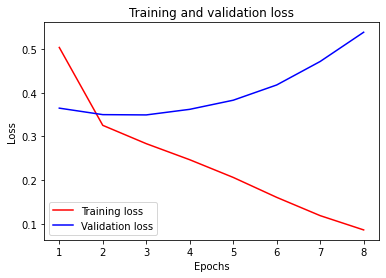

In [20]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# r은 "빨간 실선"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

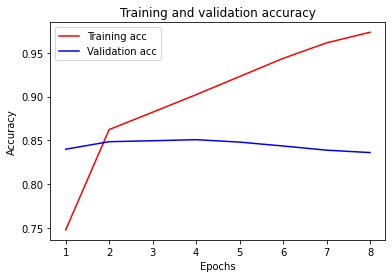

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## RNN LSTM

In [22]:
# RNN LSTM

vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 41  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))   
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [23]:

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=callbacks, #epoch 효율을 위해 earlyStopping setting
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
170/170 [==============================] - 4s 16ms/step - loss: 0.6116 - accuracy: 0.6988 - val_loss: 0.3799 - val_accuracy: 0.8396
Epoch 2/20
170/170 [==============================] - 2s 13ms/step - loss: 0.3460 - accuracy: 0.8573 - val_loss: 0.3626 - val_accuracy: 0.8434
Epoch 3/20
170/170 [==============================] - 2s 13ms/step - loss: 0.3093 - accuracy: 0.8745 - val_loss: 0.3593 - val_accuracy: 0.8466
Epoch 4/20
170/170 [==============================] - 2s 13ms/step - loss: 0.2929 - accuracy: 0.8831 - val_loss: 0.3631 - val_accuracy: 0.8441
Epoch 5/20
170/170 [==============================] - 2s 13ms/step - loss: 0.2760 - accuracy: 0.8905 - val_loss: 0.3686 - val_accuracy: 0.8436
Epoch 6/20
170/170 [==============================] - 2s 13ms/step - loss: 0.2680 - accuracy: 0.8932 - val_loss: 0.3712 - val_accuracy: 0.8440
Epoch 7/20
170/170 [==============================] - 2s 13ms/step - loss: 0.2578 - accuracy: 0.8981 - val_loss: 0.3713 - val_accuracy: 0.8456

In [24]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


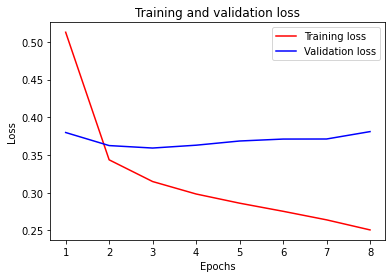

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# r은 "빨간 실선"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

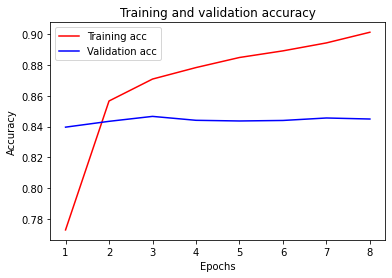

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding layer

In [27]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.03558902,  0.02876546, -0.10477822, -0.02562265, -0.05104968,
       -0.0454869 , -0.04664892, -0.06724794,  0.02329234,  0.11233747,
       -0.0625319 ,  0.0688303 , -0.1124145 ,  0.06407826, -0.10976309,
       -0.09513972, -0.0250829 , -0.12836036, -0.09522243, -0.03255121,
       -0.10687636,  0.00762624, -0.05879157, -0.10091185,  0.0065286 ,
       -0.11587658, -0.06989713, -0.04367779, -0.08418983, -0.08857691,
       -0.10034151, -0.05973779, -0.01690262, -0.00338366, -0.08742443,
       -0.08317483, -0.11109748, -0.01767917, -0.07934242, -0.09003107,
       -0.07582008], dtype=float32)

In [30]:
# '재미'와 유사한 단어 확인
word_vectors.similar_by_word("재미")

[('에서', 0.7843987941741943),
 ('타', 0.745458722114563),
 ('했', 0.7452518939971924),
 ('이거', 0.7426004409790039),
 ('뚝', 0.7409270405769348),
 ('몇', 0.7396203875541687),
 ('아닌', 0.7336767315864563),
 ('..', 0.7318112850189209),
 ('많', 0.7296087741851807),
 ('정말로', 0.7253357768058777)]

### Word2Vec 임베딩 활용하여 성능개선

In [31]:
# 한국어 Word2Vec 사용
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['시간']
vector


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.3796269 , -0.37398475, -1.2154474 ,  1.639952  , -0.14050427,
       -1.01211   , -1.0307423 ,  2.878987  ,  0.27843258, -0.761006  ,
        0.5472557 , -1.1294783 , -0.08750254,  0.31699726, -3.3931959 ,
       -0.70248127,  0.446383  ,  0.35330325, -1.7166852 ,  0.25102478,
       -1.3903627 , -0.09533731,  1.2566968 ,  0.5688976 ,  0.44297022,
       -0.97487795,  0.38161275,  0.16240513, -1.3098637 ,  0.6540781 ,
        1.1373658 , -1.2157583 , -0.16933535,  1.8439229 , -1.6933241 ,
        1.0440814 , -1.7979567 , -0.7233666 ,  1.8768268 ,  1.1397793 ,
       -1.1344665 , -3.1387126 ,  1.1286664 , -1.703793  ,  0.06359997,
        1.1868192 , -2.6793232 ,  0.12761039,  1.1400706 , -0.4587391 ,
        0.3916111 ,  0.2515998 , -0.61260563, -2.445033  ,  0.6308604 ,
        1.4974746 , -0.41639408,  0.43178192,  0.02070529, -1.2697713 ,
       -0.91432554,  0.4695733 , -1.4464544 ,  1.5261189 , -0.8574424 ,
        3.0626788 ,  0.4669899 ,  2.3038158 ,  0.9814439 , -3.25

In [32]:
# 향상된 개선모델
word2vec.similar_by_word("재미")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

## 개선된 simple GlobalMaxPooling1D Model

In [33]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 한글에서는 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

embedding_matrix.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(10000, 200)

In [34]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                  embeddings_initializer=Constant(embedding_matrix),input_length=maxlen,trainable=True))   

# model4.add(keras.layers.GlobalMaxPooling1D())
# model4.add(keras.layers.Dense(8, activation='relu'))
# model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.add(keras.layers.LSTM(512))  
model4.add(keras.layers.Dense(1, activation='sigmoid'))  

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,468,449
Trainable params: 3,468,449
Non-trainable params: 0
_________________________________________________________________


In [35]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=callbacks, #epoch 효율을 위해 earlyStopping setting
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
170/170 [==============================] - 30s 168ms/step - loss: 0.5621 - accuracy: 0.6919 - val_loss: 0.3921 - val_accuracy: 0.8229
Epoch 2/5
170/170 [==============================] - 28s 166ms/step - loss: 0.3598 - accuracy: 0.8412 - val_loss: 0.3519 - val_accuracy: 0.8493
Epoch 3/5
170/170 [==============================] - 28s 167ms/step - loss: 0.2945 - accuracy: 0.8748 - val_loss: 0.3298 - val_accuracy: 0.8554
Epoch 4/5
170/170 [==============================] - 29s 169ms/step - loss: 0.2522 - accuracy: 0.8964 - val_loss: 0.3373 - val_accuracy: 0.8548
Epoch 5/5
170/170 [==============================] - 29s 169ms/step - loss: 0.2095 - accuracy: 0.9160 - val_loss: 0.3741 - val_accuracy: 0.8552
1537/1537 - 12s - loss: 0.3843 - accuracy: 0.8531
[0.3843030631542206, 0.8531033396720886]


In [36]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


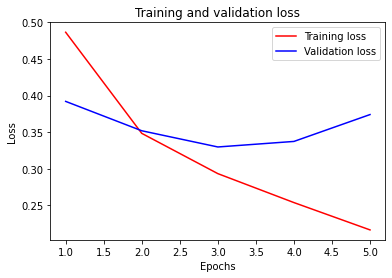

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# r은 "빨간 실선"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

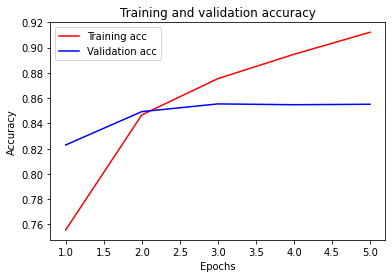

In [38]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 정리

세 가지 모델을 가지고 비교했는데 나의 경우는 LSTM Model이 가장 우수한 결과를 만들었다.  
처리 속도도 가장 좋았다.  
그래서 추가적으로 word2vec 적용한 개선 모델 설계와 테스트를 진행하였다.  
그런데 이 테스트에서도 LSTM모델이 가장 우수한 결과를 보였다.  
epoch은 20을 기본으로 세팅하고 실행하였는데, 그 중간에 가장 높은 스코어를 지나치는 경우가 있어 
 최적 epoch를 설정하기위해 'early stopping'을 설정하였다. 그리고 validation data와 test data 밸런스를 조정하여 테스트 결과 목표치인 validation accruacy 85%를 넘을 수 있었다.  
 
word_vectors.similar_by_word("재미")에서는  
('에서','탓','돼','이거','뚝','오프닝' 등)와 같은 '재미'와 다소 공감하기 힘든 단어들을 반환했다.  
반면 word2vec.similar_by_word("재미")에서는  
('취미','유머','매력','흥미','즐거움','관객',향수' 등)와 같은 '재미'와 밀접한 단어들을 반환했다.  
한국어에는 word2vec을 쓰는 것이 더 유의미한 결과를 만들어냈음을 알 수 있다.

